In [ ]:
pip install transformers torch scikit-learn pandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Carregar a base de dados
df = pd.read_csv('/content/bot_detection_data.csv')

# Visualizar as primeiras linhas do dataset
print(df.head())


   User ID        Username                                              Tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       Location           Created At            Hashtags  
0     Adkinston  2020

In [ ]:
df = df.sample(frac=0.1, random_state=42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


In [ ]:
df.isnull().sum()

,0
User ID,0
Username,0
Tweet,0
Retweet Count,0
Mention Count,0
Follower Count,0
Verified,0
Bot Label,0
Location,0
Created At,0


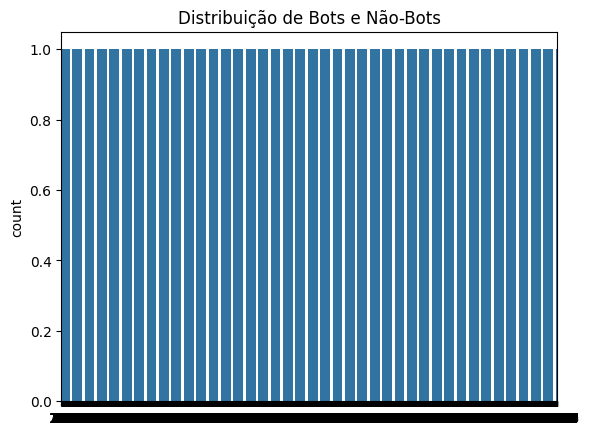

In [ ]:
# Distribuição de bots (rótulos)
sns.countplot(df['Bot Label'])
plt.title('Distribuição de Bots e Não-Bots')
plt.show()


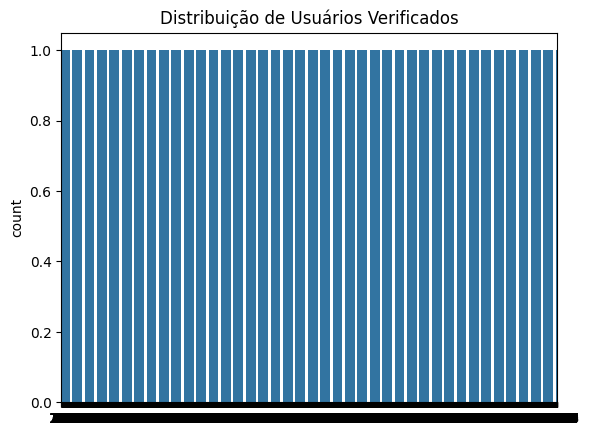

In [ ]:
# Distribuição de usuários verificados
sns.countplot(df['Verified'])
plt.title('Distribuição de Usuários Verificados')
plt.show()


In [ ]:
# Correlação entre variáveis numéricas
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as variáveis')
plt.show()

ValueError: could not convert string to float: 'wellsvicki'

In [ ]:
# Preencher valores nulos na coluna de Hashtags com uma string vazia
df['Hashtags'].fillna('', inplace=True)

# Conferir valores nulos restantes
print(df.isnull().sum())


User ID           0
Username          0
Tweet             0
Retweet Count     0
Mention Count     0
Follower Count    0
Verified          0
Bot Label         0
Location          0
Created At        0
Hashtags          0
dtype: int64


In [ ]:
# Usar LabelEncoder para variáveis categóricas
encoder = LabelEncoder()

df['Location'] = encoder.fit_transform(df['Location'])
df['Verified'] = df['Verified'].astype(int)  # Já é binário (True/False)


In [ ]:
# Normalizar variáveis numéricas como 'Retweet Count' e 'Follower Count'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Retweet Count', 'Mention Count', 'Follower Count']] = scaler.fit_transform(df[['Retweet Count', 'Mention Count', 'Follower Count']])


In [ ]:
# Definir as features (recursos) e os rótulos
features = df[['Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Location', 'Hashtags']]
labels = df['Bot Label'].values


In [ ]:
# Dividir os dados em treino (80%) e teste (20%)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {len(train_features)}")
print(f"Tamanho do conjunto de teste: {len(test_features)}")


Tamanho do conjunto de treino: 4000
Tamanho do conjunto de teste: 1000


In [ ]:
# Carregar o tokenizer do BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizar os tweets de treino e teste
train_encodings = tokenizer(list(train_features['Tweet']), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_features['Tweet']), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Converter encodings e rótulos em tensores para PyTorch
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)

# Preparar DataLoader para gerenciamento do treinamento
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
# Carregar o modelo BERT para classificação
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Colocar o modelo em modo de treinamento
model.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Definir o otimizador
optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 3  # Número de épocas

for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        # Zerar os gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Atualizar os parâmetros
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader)}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 0.7002172086238861
Epoch 2 - Loss: 0.6937689197063446
Epoch 3 - Loss: 0.6978126459121704


In [ ]:
model.eval()  # Colocar o modelo em modo de avaliação

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Forward pass sem cálculo de gradientes
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Obter as previsões
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Calcular a acurácia
accuracy = accuracy_score(true_labels, predictions)
print(f"Acurácia: {accuracy}")

# Exibir relatório detalhado de métricas
print(classification_report(true_labels, predictions, target_names=['Não-Bot', 'Bot']))


Acurácia: 0.469
              precision    recall  f1-score   support

     Não-Bot       0.00      0.00      0.00       531
         Bot       0.47      1.00      0.64       469

    accuracy                           0.47      1000
   macro avg       0.23      0.50      0.32      1000
weighted avg       0.22      0.47      0.30      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
